# HW3
Please do the following in a jupyter notebook
- There is a csv under the data folder called `hw3.csv`
- the goal of this hw is to calculate volumeUSD by chain

Some hints for this hw:
- volumeUSD = volume * close
- you will need to clean data
- visualize your data to better understand what is going on

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
data = pd.read_csv('D:\\UCB\\Pre-MFE 2022\\Python\\UCB-MFE-python-preprogram\\Lectures\\Lecture 3\\data\\hw3.csv')
data.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


As expected, we see the column "volumeUSD" is missing all the data. The volume and chain columns don't have any nulls, but the high, low and close are missing data

In [4]:
data.chain.value_counts()

ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64

There doesn't seem to be weirdly labeled chains

In [5]:
data.token.value_counts()

BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

We have some bad formatting for the token names

In [6]:
data.duplicated().sum()

307

We have 307 duplicated values that need to be removed

We plot by token to explore the data

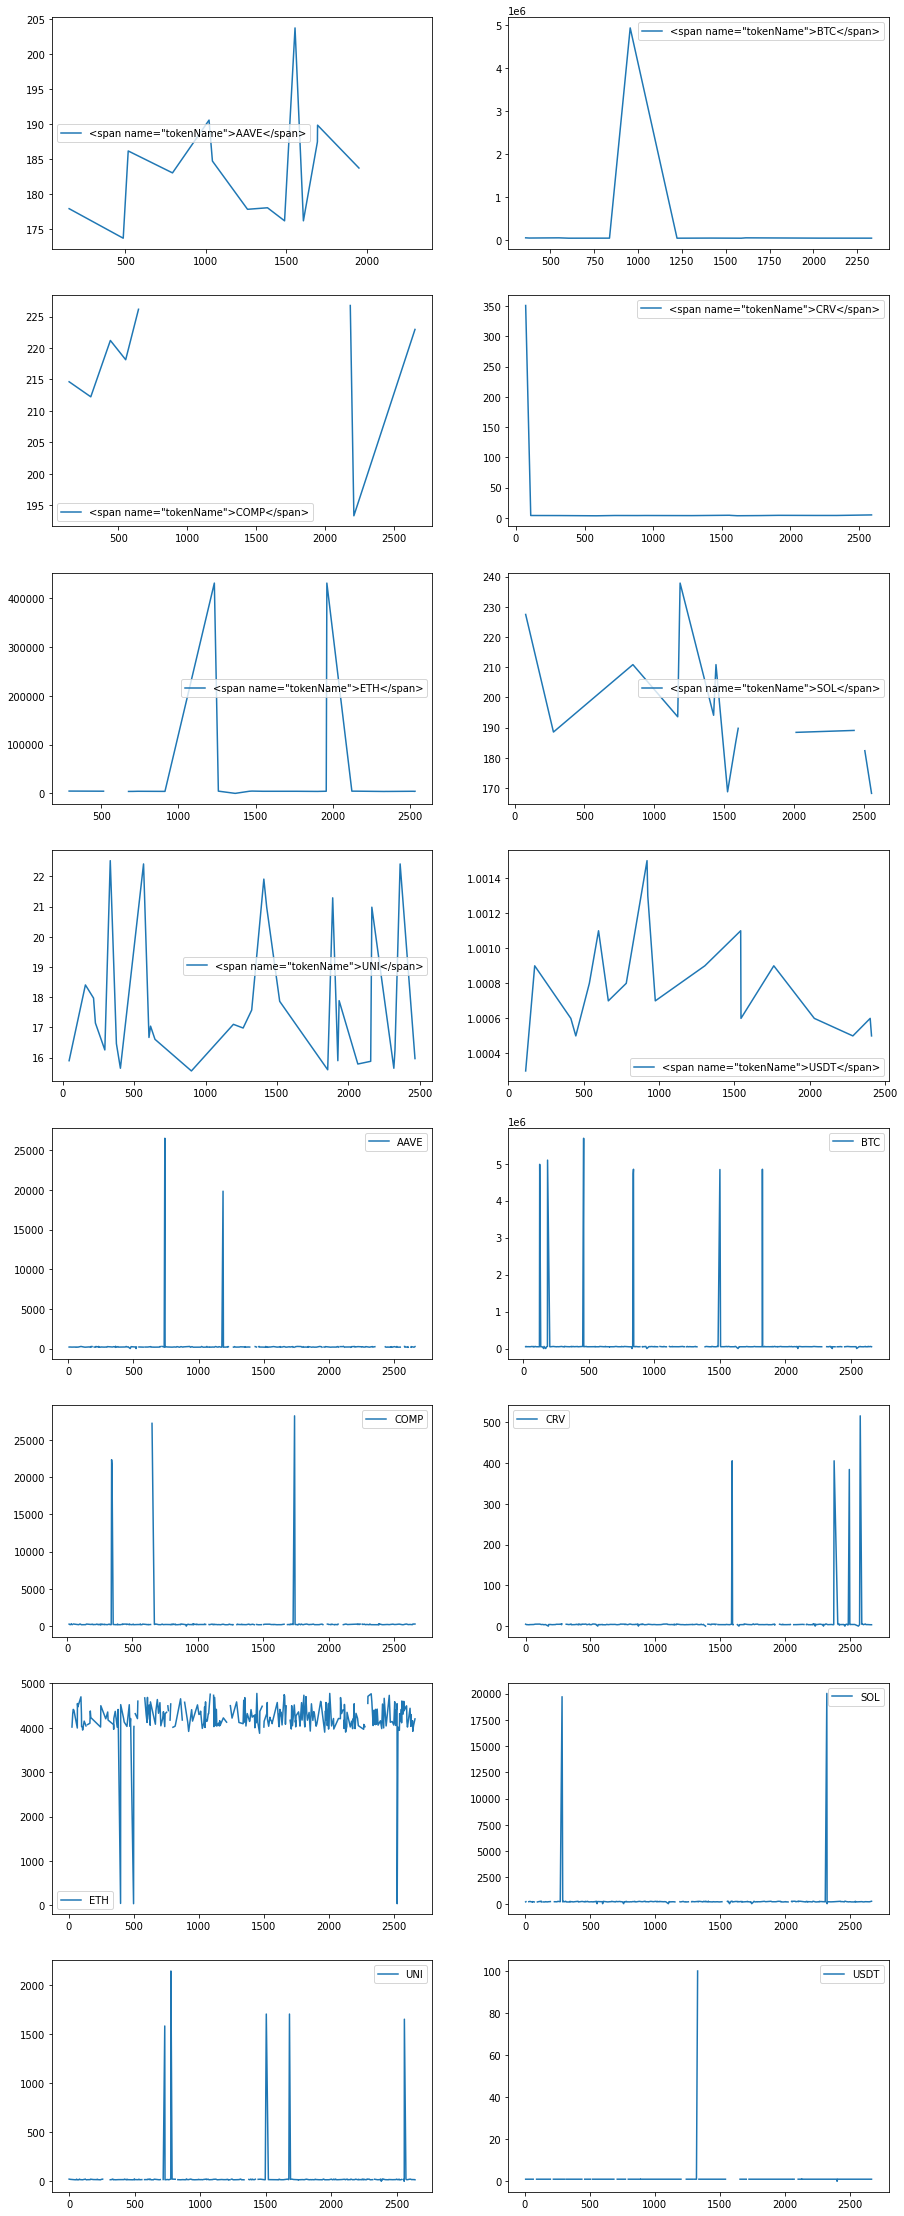

In [7]:
tokens_in_df = data.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in data[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


There are some clear outliers and missing data. We will follow a process similar to the data cleaning example.

#### 1. drop duplicates

In [8]:
data = data.drop_duplicates()

In [9]:
data.duplicated().sum()

0

#### 2. Correct token names

In [10]:
data.loc[data['token'].str.contains('<span name="tokenName">'), 'token'] = data.loc[data['token'].str.contains('<span name="tokenName">'), 'token'].str.replace('<span name="tokenName">', '')
data.loc[data['token'].str.contains('</span>'), 'token'] = data.loc[data['token'].str.contains('</span>'), 'token'].str.replace('</span>', '')

In [11]:
data.token.unique()

array(['UNI', 'CRV', 'SOL', 'ETH', 'AAVE', 'USDT', 'COMP', 'BTC'],
      dtype=object)

#### 3. Find and correct missing values and outliers

In [12]:
data.loc[~np.isfinite(data['close']), 'token'].value_counts()

USDT    19
AAVE    19
ETH     15
COMP    15
UNI     14
SOL     13
CRV     12
BTC      9
Name: token, dtype: int64

In [13]:
data.loc[pd.isnull(data['close']), 'token'].value_counts()

USDT    19
AAVE    19
ETH     15
COMP    15
UNI     14
SOL     13
CRV     12
BTC      9
Name: token, dtype: int64

To check what data can be used to fill these values, we look if the high and low values are null in the same rows:

In [14]:
data.loc[((pd.isnull(data['close'])) & ((pd.isnull(data['high'])) | (pd.isnull(data['low'])))), 'token'].value_counts()

USDT    8
AAVE    6
SOL     5
ETH     4
UNI     3
COMP    3
BTC     2
CRV     2
Name: token, dtype: int64

In this case were we don't have the high and low values (very few cases), we use the open value as as the best estimate

In [15]:
data.loc[((pd.isnull(data['close'])) & ((pd.isnull(data['high'])) | (pd.isnull(data['low'])))), 'close'] = data.loc[((pd.isnull(data['close'])) & ((pd.isnull(data['high'])) | (pd.isnull(data['low'])))), 'open'] 

When we have the high and low prices of the day, we estimate the close as the average of both values

In [16]:
data.loc[pd.isnull(data['close']), 'close'] = 0.5 *  data.loc[pd.isnull(data['close']), 'high'] + 0.5 * data.loc[pd.isnull(data['close']), 'low']

Recheck the data to verify we don't have any other missing values: 

In [17]:
data.loc[~np.isfinite(data['close']), 'token'].value_counts()

Series([], Name: token, dtype: int64)

In [18]:
data.loc[pd.isnull(data['close']), 'token'].value_counts()

Series([], Name: token, dtype: int64)

We now need to solve the outliers problem:

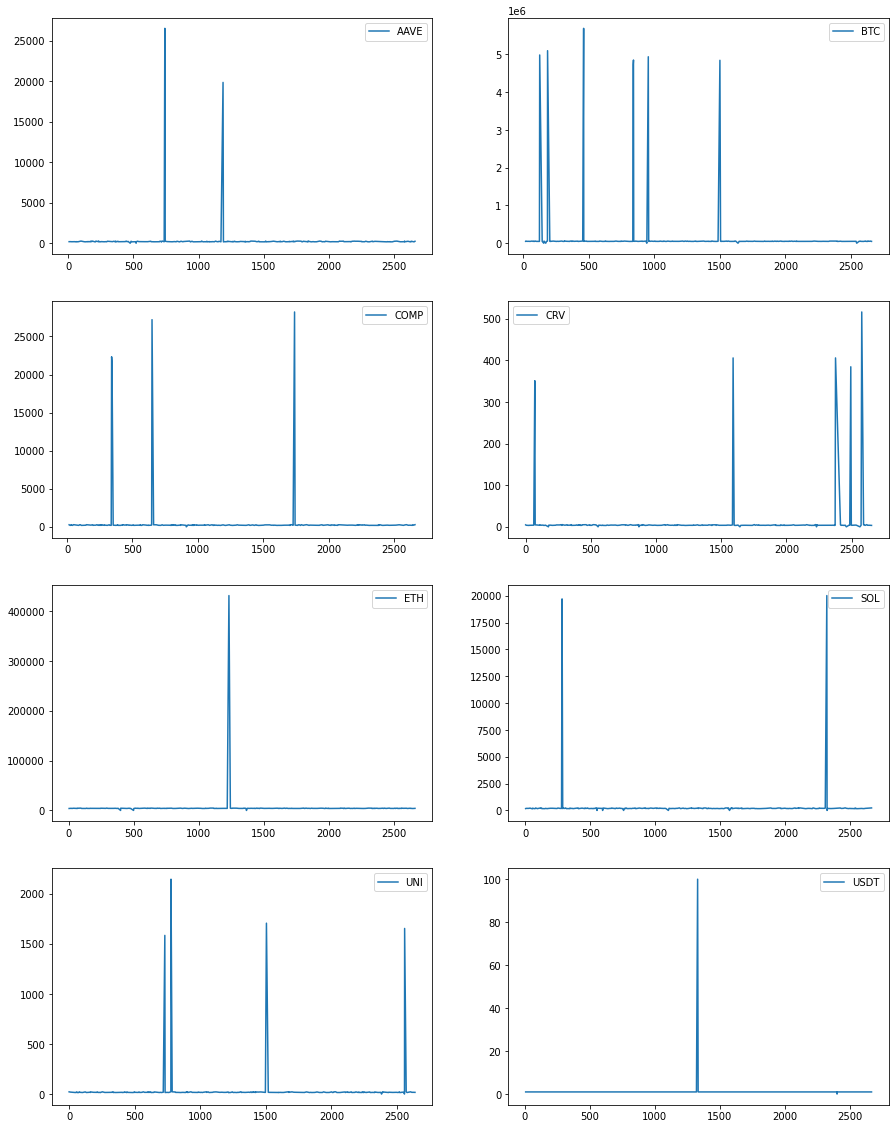

In [19]:
tokens_in_df = data.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in data[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1

We define the same heuristic for an outlier as in the example:

In [20]:
data.loc[data.close / data.open >= 2]

,ts,open,high,low,close,volume,volumeUSD,token,chain
71,2021-12-10 21:00:00,3.4600,3.5100,3.4600,351.00,1.080245e+05,NaN,CRV,ETH
127,2021-12-12 14:00:00,49542.3900,NaN,49534.7100,4983812.00,3.426704e+02,NaN,BTC,BTC
187,2021-12-07 08:00:00,51224.9900,51398.2600,50883.3400,5097338.00,4.433800e+02,NaN,BTC,BTC
282,2021-12-07 18:00:00,197.0930,197.8000,194.3450,19698.90,6.369084e+04,NaN,SOL,SOL
341,2021-12-08 01:00:00,223.8500,224.9800,220.3900,22333.00,1.477532e+03,NaN,COMP,ETH
344,2021-12-08 12:00:00,214.8900,217.1000,212.3800,21568.00,2.372441e+03,NaN,COMP,ETH
462,2021-12-02 23:00:00,56904.6500,56952.8100,56639.4900,5688883.00,3.821792e+02,NaN,BTC,BTC
650,2021-12-02 02:00:00,269.7800,272.1200,268.2900,27212.00,4.564180e+02,NaN,COMP,ETH
730,2021-12-06 07:00:00,16.0391,16.2298,15.8308,1584.74,7.441640e+04,NaN,UNI,ETH
741,2021-12-01 11:00:00,266.9360,267.9630,264.2370,26501.50,1.018631e+03,NaN,AAVE,ETH


Examining the data, we can notice the problem is that the closing price has been multiplied by a factor. We can verify:

In [21]:
data.loc[data.close / data.open >= 2].close / data.loc[data.close / data.open >= 2].open

71      101.445087
127     100.596923
187      99.508814
282      99.947233
341      99.767702
344     100.367630
462      99.972199
650     100.867373
730      98.804796
741      99.280352
777      98.776048
840      99.238085
842      99.800782
955     100.517983
1188     99.721939
1233    100.070111
1329    100.009991
1501    100.632126
1505    100.489298
1591     99.241683
1740     99.847868
2319    101.458755
2376    103.331126
2493     97.979000
2559    100.187165
2577     97.879684
dtype: float64

My guess is that the prices were modified by a factor of 100 which caused them to be outliers. We re-scale the values to correct the information:

In [22]:
data.loc[data.close / data.open >= 2, 'close'] = data.loc[data.close / data.open >= 2, 'close']/100.0

We look at the data again to verify:

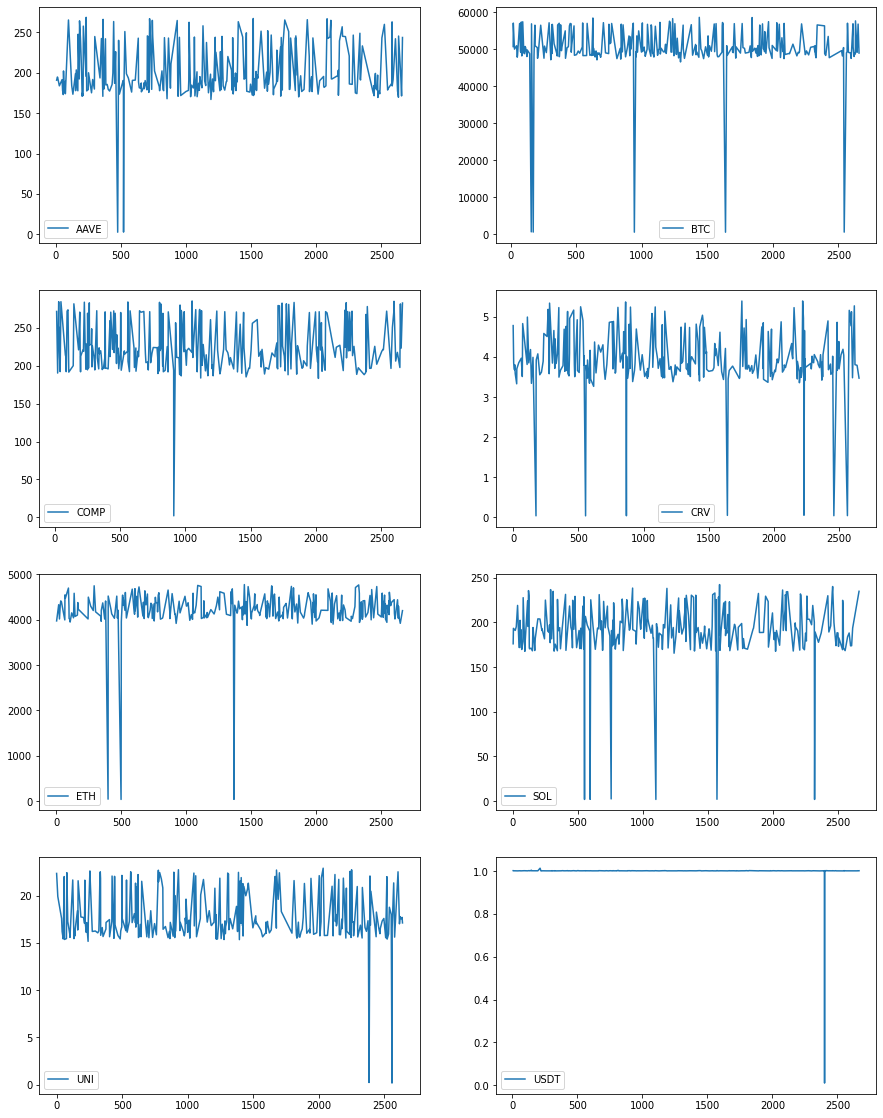

In [23]:
tokens_in_df = data.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in data[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1

After cleaning the outliers, we can notice now there are outliers where the value of the close price is near cero. Those were not visible before because of the scale. We define another heuristic to filter them:

In [24]:
data.loc[data.close / data.open <= 0.5] #it is suspicious that the value of the coin halves in a single day

,ts,open,high,low,close,volume,volumeUSD,token,chain
158,2021-12-03 12:00:00,56891.7000,57209.7000,56858.0200,570.337400,1.897550e+02,NaN,BTC,BTC
173,2021-12-07 07:00:00,50941.5000,51272.8300,50936.0500,512.250000,3.124719e+02,NaN,BTC,BTC
176,2021-12-06 01:00:00,3.6302,3.6365,3.4638,0.035758,4.227913e+05,NaN,CRV,ETH
399,2021-12-03 08:00:00,4584.3400,4588.0300,4548.0600,45.722700,2.468821e+03,NaN,ETH,ETH
475,2021-12-02 08:00:00,245.8090,247.5180,245.7290,2.467160,3.166740e+02,NaN,AAVE,ETH
499,2021-12-10 23:00:00,3996.1700,NaN,3953.7700,39.613200,8.379371e+03,NaN,ETH,ETH
520,2021-12-01 17:00:00,265.2620,NaN,262.9060,2.632300,9.809190e+02,NaN,AAVE,ETH
551,2021-12-11 12:00:00,171.8500,172.4100,169.9900,1.700800,1.572705e+04,NaN,SOL,SOL
556,2021-12-10 08:00:00,3.5900,3.6300,3.5400,0.035700,1.034540e+05,NaN,CRV,ETH
594,2021-12-09 21:00:00,181.3980,181.9630,178.7750,1.809360,1.044998e+05,NaN,SOL,SOL


Again we check for a common probable factor and correct accordingly:

In [25]:
data.loc[data.close / data.open <= 0.5].close / data.loc[data.close / data.open <= 0.5].open

158     0.010025
173     0.010056
176     0.009850
399     0.009974
475     0.010037
499     0.009913
520     0.009923
551     0.009897
556     0.009944
594     0.009975
756     0.010203
869     0.009736
912     0.010181
944     0.010080
1100    0.010110
1368    0.009982
1570    0.009957
1639    0.009961
1643    0.010152
2230    0.010300
2321    0.009958
2383    0.010010
2401    0.009997
2459    0.010041
2544    0.010016
2558    0.010028
2563    0.009867
dtype: float64

In [26]:
data.loc[data.close / data.open <= 0.5, 'close'] = data.loc[data.close / data.open <= 0.5, 'close']*100.0

Check again:

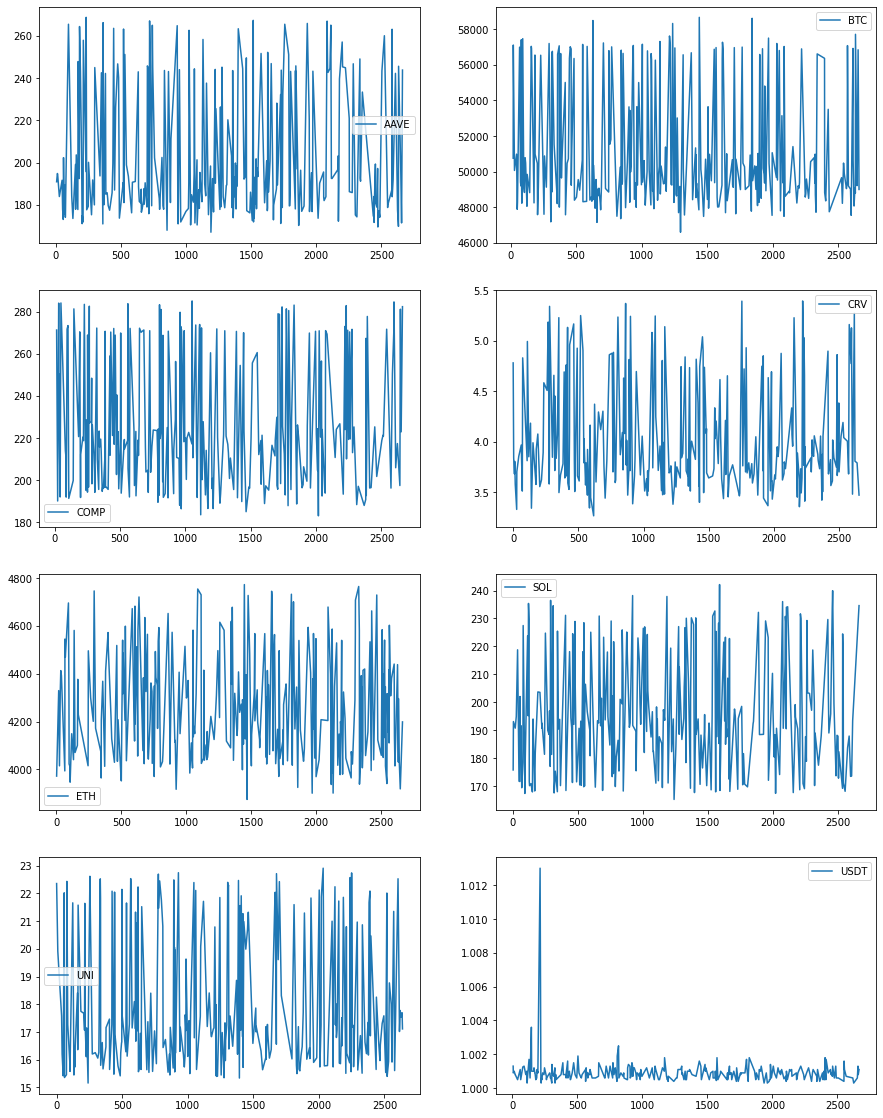

In [27]:
tokens_in_df = data.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in data[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1

The only suspicious value remaining is the Tether outlier, which may or may not be real:

In [28]:
data.loc[(data.token == 'USDT') & (data.close > 1.01)]

,ts,open,high,low,close,volume,volumeUSD,token,chain
214,2021-12-04 06:00:00,1.0011,1.025,1.001,1.013,32828498.67,NaN,USDT,USDT


We notice that the daily high is coherent with the high closing mark price, which may point to the fact that the data is real. I opt to leave the value unchanged.

Now we must check the data for the volume field of each token:

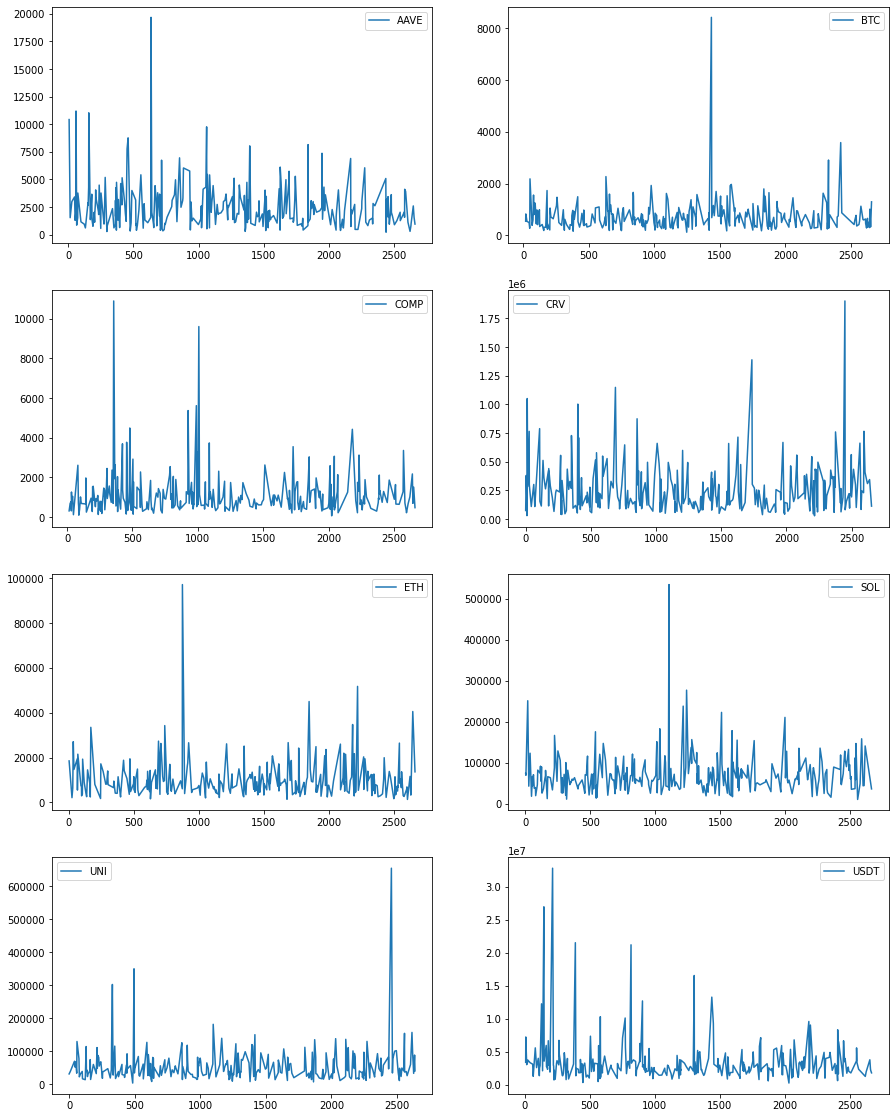

In [29]:
tokens_in_df = data.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in data[['token', 'volume']].groupby('token'):
    df_token['volume'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1

The data has some outliers, but they are mostly consistent between diferent coins: For instance, the outlier in the UNI token is also seen for the CRV at around the same period. Moreover, there can be highly intensive trading sessions, so to clear this data each case should be analyzed particularly. I'll leave the spikes as they are.

We now calculate the volumeUSD column and group by chain:

In [30]:
data.volumeUSD = data.close * data.volume

In [31]:
data[['chain','volumeUSD']].groupby('chain').sum()

,volumeUSD
chain,
BTC,1.096012e+10
ETH,1.367033e+10
SOL,4.077186e+09
USDT,1.008249e+09
